In [4]:
import cv2
import random
import numpy  as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot    as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-18 22:21:11.197869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 22:21:11.198049: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 22:21:11.198236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 22:21:11.321479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 22:21:14.199921: W tensorflow/compiler/

In [2]:
Train_Images = pd.read_csv("/home/ai/Development/alifLam/dataset/csvTrainImages 13440x1024.csv")
Train_Labels = pd.read_csv("/home/ai/Development/alifLam/dataset/csvTrainLabel 13440x1.csv")

Test_Images = pd.read_csv("/home/ai/Development/alifLam/dataset/csvTestImages 3360x1024.csv")
Test_Labels = pd.read_csv("/home/ai/Development/alifLam/dataset/csvTestLabel 3360x1.csv")

In [3]:
print(f"Train Iamges Shape : {Train_Images.shape}")
print(f"Test  Iamges Shape : {Test_Images.shape}")

print(f"Train Labels Shape : {Train_Labels.shape}")
print(f"Test  Labels Shape : {Test_Labels.shape}")

Train Iamges Shape : (13439, 1024)
Test  Iamges Shape : (3359, 1024)
Train Labels Shape : (13439, 1)
Test  Labels Shape : (3359, 1)


In [4]:
all_images = pd.concat([Train_Images, Test_Images], axis=0)
all_labels = pd.concat([Train_Labels, Test_Labels], axis=0)

In [5]:
# split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=69)
print(f"X_train Shape : {X_train.shape}")
print(f"X_test  Shape : {X_test.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"y_test  Shape : {y_test.shape}")

X_train Shape : (13438, 1106)
X_test  Shape : (3360, 1106)
y_train Shape : (13438, 1)
y_test  Shape : (3360, 1)


In [5]:
arabic_chars = {0: 'alif',
                1: 'ba',
                2: 'ta',
                3: 'tsa',
                4: 'jim',
                5: 'kha',
                6: 'kho',
                7: 'dal',
                8: 'dzal',
                9: 'ra',
                10: 'zai',
                11: 'sin',
                12: 'syin',
                13: 'shad',
                14: 'dhad',
                15: 'tha',
                16: 'dha',
                17: 'ain',
                18: 'ghain',
                19: 'fa',
                20: 'qaf',
                21: 'kaf',
                22: 'lam',
                23: 'mam',
                24: 'nun',
                25: 'Ha',
                26: 'waw',
                27: 'ya'
               }

In [7]:
X_train = Train_Images.to_numpy()
y_train = Train_Labels.to_numpy()-1 

X_test = Test_Images.to_numpy()
y_test = Test_Labels.to_numpy()-1
print(f"X_Train Shape : {X_train.shape}")
print(f"X_Test  Shape : {X_test.shape}")
print(f"Y_Train Shape : {y_train.shape}")
print(f"Y_Test  Shape : {y_test.shape}")

X_Train Shape : (13439, 1024)
X_Test  Shape : (3359, 1024)
Y_Train Shape : (13439, 1)
Y_Test  Shape : (3359, 1)


In [8]:
X_train = X_train.reshape(-1,32,32,1) / 255.0
X_test  = X_test.reshape(-1,32,32,1)  / 255.0

In [9]:
# rotate the images 90 degree clockwise
X_train = np.rot90(X_train, axes=(1,2))
X_train = np.fliplr(X_train)
X_test  = np.rot90(X_test, axes=(1,2))
X_test  = np.fliplr(X_test)

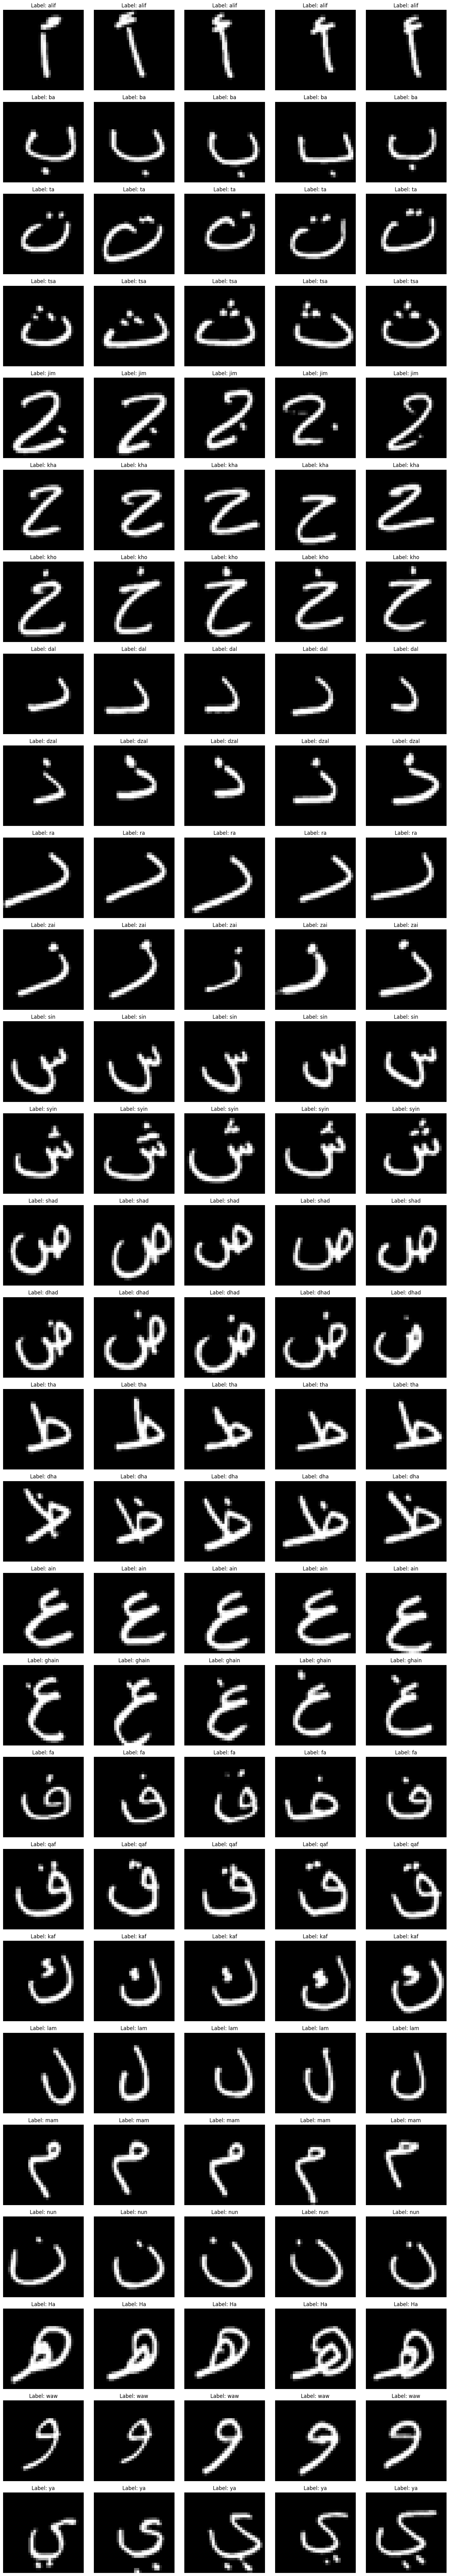

In [10]:
unique_labels = np.unique(y_train)
num_images_per_label = 5
num_rows = len(unique_labels)
num_cols = num_images_per_label
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
for row, label in enumerate(unique_labels):
    indices = np.where(y_train == label)[0]    
    for col, index in enumerate(indices[:num_images_per_label]):
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(X_train[index], cmap='gray')
        ax.set_title(f"Label: {arabic_chars[int(label)]}")
        ax.axis('off')
for i in range(num_rows * num_cols - len(unique_labels)):
    axes.flatten()[-(i + 1)].axis('off')
plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
print(y_train.shape,y_train.shape)

(13439, 28) (13439, 28)


In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode ="nearest"
)
# test_datagen = ImageDataGenerator()
train_gen = datagen.flow(X_train, y_train, batch_size=32)
test_gen  = datagen.flow(X_test , y_test , batch_size=32)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class ArabicCNN():
    def __init__(self, input_shape=(32, 32, 1), num_classes=28):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
                Conv2D(64, (5, 5), padding="same", activation="relu", input_shape=self.input_shape, kernel_regularizer=l2(0.001)),
                Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
                MaxPooling2D((2, 2)),
                BatchNormalization(),
                Conv2D(128, (5, 5), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
                Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
                MaxPooling2D((2, 2)),
                BatchNormalization(),
                SeparableConv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
                SeparableConv2D(256, (2, 2), activation="relu", kernel_regularizer=l2(0.001)),
                MaxPooling2D((2, 2)),
                BatchNormalization(),
                GlobalAveragePooling2D(),
                Dense(512, activation="relu"),
                Dropout(0.5),
                Dense(256, activation="relu"),
                Dropout(0.5),
                Dense(self.num_classes, activation="softmax")
            ])
        return model

    def compile_model(self):
        self.model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

    def summary(self):
        self.model.summary()
    
    def fit_model(self, train_gen, epochs, verbose=1, steps_per_epoch=None, validation_data=None, validation_steps=None, callbacks=None):
        history = self.model.fit(
            train_gen,
            epochs=epochs,
            verbose=verbose,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data,
            validation_steps=validation_steps,
            callbacks=callbacks
        )
        return history
    
    def predict(self, x):
        return self.model.predict(x)
    
    def save(self):
        return self.model.save("100624_arabic_model.h5")

model = ArabicCNN()
model.compile_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       1

2024-06-16 20:00:55.164828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 20:00:55.186236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 20:00:55.186519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 28)                7196      
                                                                 
Total params: 763996 (2.91 MB)
Trainable params: 763100 (2.91 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import activation function

class ArabicCNN():
    def __init__(self, input_shape=(32, 32, 1), num_classes=28):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
                Conv2D(64, (5, 5), padding="same", activation=None, input_shape=self.input_shape, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Activation('relu'),
                Conv2D(64, (3, 3), activation=None, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Activation('relu'),
                MaxPooling2D((2, 2)),
                Conv2D(128, (5, 5), padding="same", activation=None, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Activation('relu'),
                Conv2D(128, (3, 3), activation=None, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Activation('relu'),
                MaxPooling2D((2, 2)),
                SeparableConv2D(256, (3, 3), padding="same", activation=None, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Activation('relu'),
                SeparableConv2D(256, (2, 2), activation=None, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Activation('relu'),
                MaxPooling2D((2, 2)),
                GlobalAveragePooling2D(),
                Dense(512, activation="relu"),
                Dropout(0.5),
                Dense(256, activation="relu"),
                Dropout(0.5),
                Dense(self.num_classes, activation="softmax")
            ])
        return model

    def compile_model(self):
        self.model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])

    def summary(self):
        self.model.summary()
    
    def fit_model(self, train_gen, epochs, verbose=1, steps_per_epoch=None, validation_data=None, validation_steps=None, callbacks=None):
        if callbacks is None:
            callbacks = [
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        history = self.model.fit(
            train_gen,
            epochs=epochs,
            verbose=verbose,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data,
            validation_steps=validation_steps,
            callbacks=callbacks
        )
        return history
    
    def predict(self, x):
        return self.model.predict(x)
    
    def save(self):
        return self.model.save("100624_arabic_model.h5")

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode ="nearest"
)
# test_datagen = ImageDataGenerator()
train_gen = datagen.flow(X_train, y_train, batch_size=32)
test_gen  = datagen.flow(X_test , y_test , batch_size=32)

model = ArabicCNN()
model.compile_model()
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1664      
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 batch_normalization_4 (Bat  (None, 30, 30, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 30, 30, 64)       

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = [
    ModelCheckpoint(
        filepath="best.keras",
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, patience=3, 
        verbose=1),
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        verbose=1, 
        restore_best_weights=True)
    ]
history = model.fit_model(
    train_gen,
    epochs=100,
    verbose=1,
    steps_per_epoch=X_train.shape[0] // 32,
    validation_data=test_gen,
    validation_steps=X_test.shape[0] // 32,
)

Epoch 1/100


2024-06-16 20:00:58.085311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-16 20:00:59.395158: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb308c436c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-16 20:00:59.395185: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-16 20:00:59.400438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-16 20:00:59.489004: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


419/419 [==============================] - 13s 16ms/step - loss: 2.2269 - accuracy: 0.3691 - val_loss: 4.2077 - val_accuracy: 0.1199 - lr: 0.0010
Epoch 2/100
419/419 [==============================] - 5s 12ms/step - loss: 1.0268 - accuracy: 0.7247 - val_loss: 0.9006 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 3/100
419/419 [==============================] - 5s 12ms/step - loss: 0.7228 - accuracy: 0.8329 - val_loss: 1.5063 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 4/100
419/419 [==============================] - 5s 12ms/step - loss: 0.6139 - accuracy: 0.8703 - val_loss: 0.7908 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 5/100
419/419 [==============================] - 5s 12ms/step - loss: 0.5298 - accuracy: 0.8995 - val_loss: 0.3835 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 6/100
419/419 [==============================] - 5s 12ms/step - loss: 0.5091 - accuracy: 0.9068 - val_loss: 0.5169 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 7/100
419/419 [==============================] - 5s 12ms/step -

In [16]:
model.save()

/home/ai/.conda/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
result = []
def predict_image(image_path, model_path, arabic_chars):
    model = tf.keras.models.load_model(model_path)

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.bitwise_not(img)  # Invert colors
    img = cv2.resize(img, (32, 32))
    # mirror the image
    img = img.reshape(-1, 32, 32, 1)
    img = img.astype('float32') / 255.0

    pred = model.predict(img)
    predicted_label = arabic_chars[np.argmax(pred)]
    # add label to image 
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    fontScale = 1
    color = (255, 0, 0)
    thickness = 2
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.bitwise_not(img)  # Invert colors
    img = cv2.resize(img, (512, 512))
    img = cv2.putText(img, predicted_label, org, font, fontScale, color, thickness, cv2.LINE_AA)
    result.append(img)
    return predicted_label


# def plot_image(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.bitwise_not(img)  # Invert colors
#     img = cv2.resize(img, (32, 32))
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
#     plt.show()

In [7]:
# # Example usage
# image_path = "/home/ai/Development/alifLam/test-set/ya.png"

# predicted_label = predict_image(image_path, model_path, arabic_chars)
# print("Predicted label:", predicted_label)

import os

model_path = "/home/ai/Development/alifLam/notebook/100624_arabic_model.h5"
test_dir = "/home/ai/Development/alifLam/test-set"
for image in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image)
    predicted_label = predict_image(image_path, model_path, arabic_chars)
    print(f"Predicted label for {image}: {predicted_label}")
    # plot_image(image_path)
    # print("\n")

# fig, axes = plt.subplots(1, len(result), figsize=(len(result) * 3, 3))
# for i, img in enumerate(result):
#     axes[i].imshow(img, cmap='gray')
#     axes[i].axis('off')

# 28 images in the test set
# fig, axes = plt.subplots(4, 7, figsize=(7 * 3, 4 * 3))
# for i, img in enumerate(result):
#     row = i // 7
#     col = i % 7
#     axes[row, col].imshow(img, cmap='gray')
#     axes[row, col].axis('off')
    

2024-06-18 22:21:24.452876: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-18 22:21:24.453039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: fedora
2024-06-18 22:21:24.453138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: fedora
2024-06-18 22:21:24.453588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.179.0
2024-06-18 22:21:24.453723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.179.0
2024-06-18 22:21:24.453772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.179.0


1/1 [==============================] - 0s 164ms/step
Predicted label for tes1.png: ra
1/1 [==============================] - 0s 122ms/step
Predicted label for tes10.png: zai
1/1 [==============================] - 0s 275ms/step
Predicted label for tes12.png: zai
1/1 [==============================] - 0s 141ms/step
Predicted label for tes13.png: syin
1/1 [==============================] - 0s 114ms/step
Predicted label for tes14.png: syin
1/1 [==============================] - 0s 351ms/step
Predicted label for tes15.png: shad
1/1 [==============================] - 0s 121ms/step
Predicted label for tes16.png: syin
1/1 [==============================] - 0s 120ms/step
Predicted label for tes17.png: tha
1/1 [==============================] - 0s 126ms/step
Predicted label for tes18.png: dha
1/1 [==============================] - 0s 408ms/step
Predicted label for tes19.png: ghain
1/1 [==============================] - 0s 118ms/step
Predicted label for tes2.png: ba
1/1 [=========================

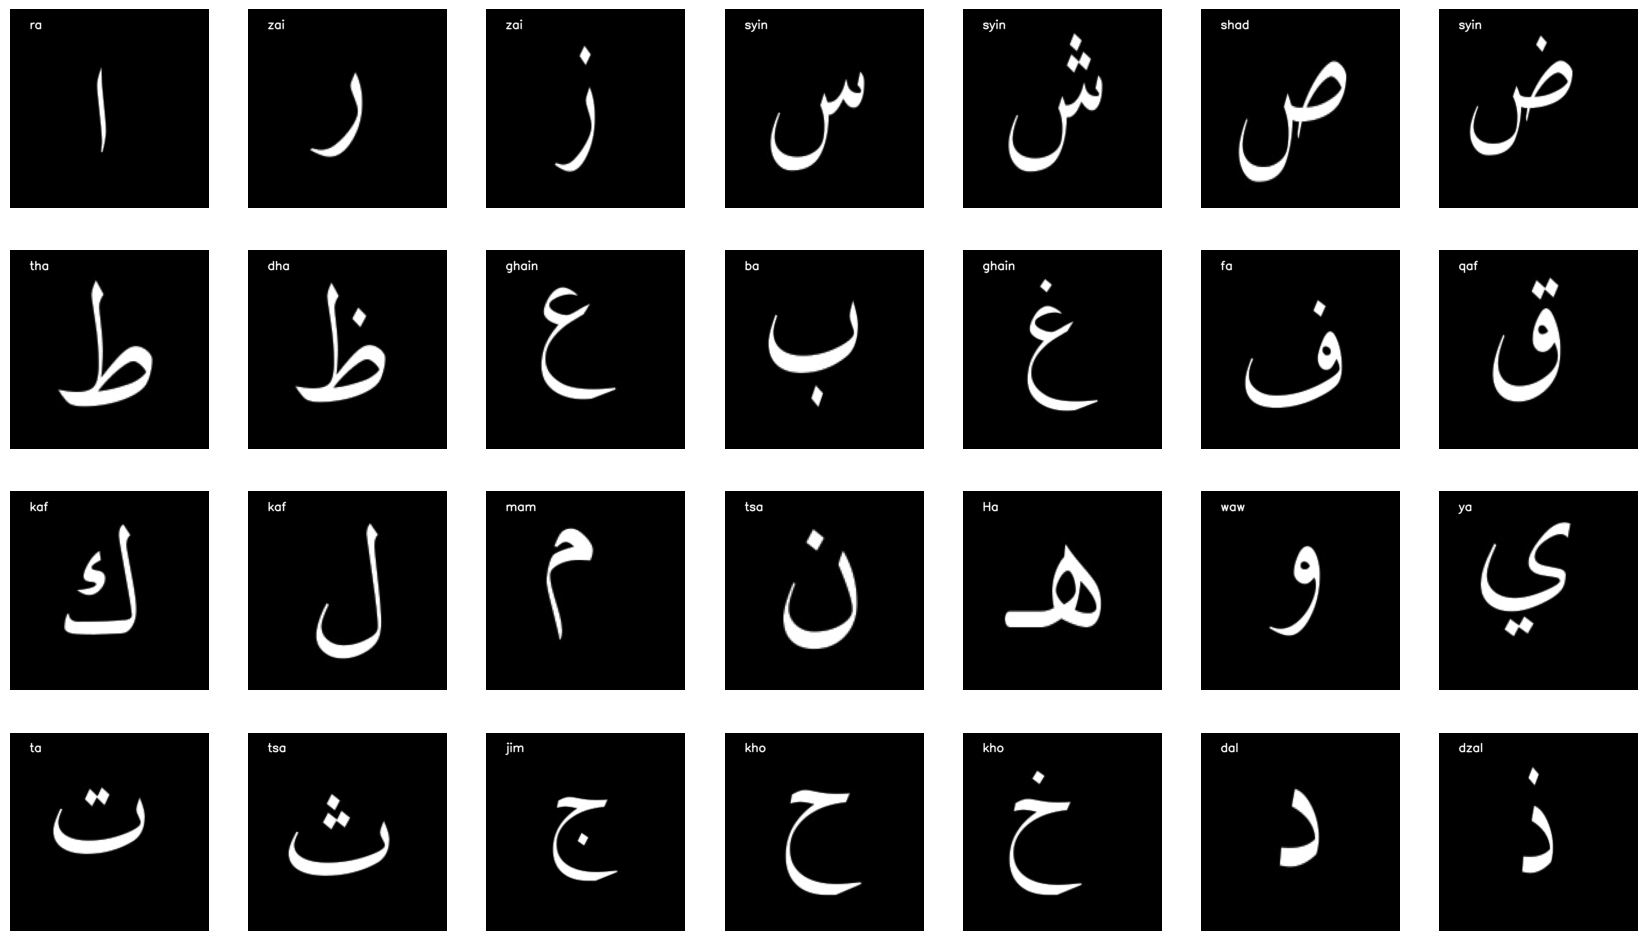

In [8]:
# show 28 images in result[]
fig, axes = plt.subplots(4, 7, figsize=(7 * 3, 4 * 3))
for i, img in enumerate(result):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')

In [9]:
print(tf.__version__)

2.14.0
